In [1]:
import scipy as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import time
import h5py as h5
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

%matplotlib inline

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-|\boldsymbol {q}R|^\alpha}
\end{equation}

Properties:

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, 2^{-\frac{1}{\alpha}}R) = \frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-\frac{1}{2}|\boldsymbol {q}R|^\alpha}
\end{equation}

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha, 1\bigg)=\frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha\bigg)
\end{equation}

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) =\mathcal{L}(r, \alpha, R) = \frac{4\pi}{(2\pi)^3}\int_0^\infty \frac{q\sin{qr}}{r}e^{-|qR|^\alpha}dq
\end{equation}

Normalization factor:
\begin{equation}
\mathcal{C} = \int_{-\infty}^\infty e^{-|qR|^\alpha}dq
\end{equation}

The integral we want to calculate with MCMC:
\begin{equation}
\mathcal{L}(r, \alpha, R) = \frac{\mathcal{C}}{2r}\frac{4\pi}{(2\pi)^3}\int_{-\infty}^\infty q\sin{qr}\frac{e^{-|qR|^\alpha}}{\mathcal{C}}dq
\end{equation}

### Asymptotic series expansion

#### Big r ($r>>1$)
\begin{equation}
\mathcal{L}(r,\alpha) \approx \frac{\alpha}{2\pi^2}\sum_{k=1}^{n}(-1)^{k+1}\frac{\Gamma(\alpha k)}{\Gamma(k)} \sin{\bigg(\frac{\pi\alpha k}{2}\bigg)}\frac{\alpha k+1}{r^{\alpha k+3}}
\end{equation}

#### Small r ($r<<1$)
\begin{equation}
\mathcal{L}(r,\alpha) \approx -\frac{1}{2\pi^2\alpha}\sum_{k=0}^n\frac{\Gamma\big(\frac{k+3}{\alpha}\big)}{\Gamma(k+3)}\sin{\bigg(\frac{\pi(k+3)}{2}\bigg)}(k+2)(k+1)x^k
\end{equation}

In [2]:
def asym_bx(x, alpha, n=10):
    s = 0.0
    for k in range(1, n+1):
        s += (-1)**(k+1)*(sp.special.gamma(alpha*k)/sp.special.gamma(k))*np.sin(0.5*np.pi*alpha*k)*(k*alpha+1)/x**(k*alpha+3)
    return s*alpha/(2*np.pi**2)

def asym_sx(x, alpha, n=10):
    s = 0.0
    for k in range(n):
        s += (sp.special.gamma((k+3)/alpha)/sp.special.gamma(k+3))*np.sin(0.5*np.pi*(k+3))*(k+2)*(k+1)*x**k
    return -s/(2*np.pi**2*alpha)

def asym_error(x, alpha, n):
    s = (sp.special.gamma(alpha*n)/sp.special.gamma(n))*(n*alpha+1)/x**(n*alpha+3)
    return s*alpha/(2*np.pi**2)

### CUDA code

In [3]:
mod=SourceModule("""
#include <curand.h>
#include <curand_kernel.h>


extern "C" {
    __global__ void init( unsigned long long int* seed, curandState * state){
        int id = threadIdx.x;
        curand_init(*seed, id, 0, &state[id]);
    }
    
    __device__ void pi(const float &x, float *pars, float &p){
        p = expf(-powf(fabsf(x*pars[2]), pars[1]));
    }
    
    __device__ void f(const float &x, float *pars, float &s){
        s += x*sinf(x*pars[0]);
    }
    
    __global__  void mcmc(curandState* states, unsigned long long int * num_samples, float * Pars, int * npar, 
                          float * Sigma, float * result){
        int id            = threadIdx.x;
        curandState state = states[id];
        unsigned long long int N    = *num_samples;
        float sigma       = *Sigma;
        float *pars       = new float[*npar];
        memcpy(pars, &Pars[*npar*id], *npar*sizeof(float));
        
        float xi   = curand_uniform(&state);
        float xg   = 0.0;
        float s    = 0.0;
        float p_xi = 0.0;
        float p_xg = 0.0;
        pi(xi, pars, p_xi);
        for(unsigned long long int i=0;i<N;i++){
            xg = sigma*curand_normal(&state)+xi;
            pi(xg, pars, p_xg);
            if (curand_uniform(&state)<(p_xg/p_xi)){
              xi   = xg;
              p_xi = p_xg;
            }
            f(xi, pars, s);
        }
        result[id] = s/float(N);
        delete pars;
    }
}
""", no_extern_c=True)

### Getting init and mcmc CUDA functions

In [4]:
init = mod.get_function("init")
mcmc = mod.get_function("mcmc")

### curandState size

In [5]:
sizeof_curandState = pycuda.characterize.sizeof('curandState', '#include <curand_kernel.h>')

## Test

In [11]:
# r parameter range divided to N part
# r parameter range, r Levy parameter
# Levy parameter  
# Levy parameter
# MCMC path length
def test(N=200, rrange=[1e-5,10], alpha=0.7, R=1, num_samples=1000000, xfu=10, xfl=3, aa=10, ab=20,n=10, aa_sx=0.0001, ab_sx=0.5):
    num_samples = np.int64(num_samples)                
    npar        = np.int32(3)                        # number of parameters: r, alpha, R
    proposal_sd = np.float32(1.0)                    # xnew = normal(xi, proposal_sigma)
    res         = np.array([0]*N, dtype=np.float32)  # array for result
    res2         = [np.array([0]*N, dtype=np.float32) for i in range(1)] # array for result

    
    rng_states = cuda.mem_alloc(N*sizeof_curandState);  #lot of start states, so the different threads rand number won't correlate
    init(cuda.In(np.int64(time.time()*100)), rng_states, block=(N,1,1))
    
    pars = np.reshape(np.array(list(map(lambda x: [x, alpha, R], np.linspace(rrange[0],rrange[1],N))), dtype=np.float32), N*3)
    
    start = time.time()
    mcmc(rng_states, cuda.In(num_samples), cuda.In(pars), cuda.In(npar), cuda.In(proposal_sd), cuda.Out(res),
     block=(N,1,1),time_kernel=True)
    rt  = time.time()-start
    print("Seconds:%.2f"%rt)
    
    start = time.time()
    for rr in range(len(res2)):
        mcmc(rng_states, cuda.In(num_samples), cuda.In(pars), cuda.In(npar), cuda.In(proposal_sd), cuda.Out(res2[rr]),
         block=(N,1,1),time_kernel=True)
    rt  = time.time()-start
    print("Seconds:%.2f"%rt)
    
    for i in range(len(res2)):
        res += res2[i]
    res /= (len(res2)+1)
    
    fLevy3D = lambda x,r, alpha,R: (x*np.sin(x*r))*np.exp(-np.power(np.linalg.norm(x)*R, alpha))
    
    if alpha>=0.6:
        x1 = np.linspace(*rrange,100)
        start = time.time()
        y1 = np.array([integrate.quad(fLevy3D, 0, np.inf, args=(q, alpha, R), limit=1000)/(2*q*np.pi**2) for q in x1])
        rt  = time.time()-start
        print("Seconds:%.2f"%rt)
    
    C = integrate.quad(lambda x, alpha, R: np.exp(-np.power(np.linalg.norm(x)*R, alpha) ), -np.inf, np.inf, args=(alpha, R))[0]
    
    mcmc_res = []
    i = 0
    for r in np.linspace(rrange[0],rrange[1],N):
        Scale = 2*np.pi*C/r/(2*np.pi)**3
        mcmc_res.append(res[i]*Scale)
        i+=1
        
    x = np.linspace(*rrange,N)
    plt.figure(0,(14,7))
    if rrange[0]>0.5:
        plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("r", fontsize=18)
    plt.ylabel("P(r)", fontsize=18)
    plt.plot(x, mcmc_res, 'x', label="MCMC result")
    if alpha>=0.6:
        plt.plot(x1,y1[:,0], lw=2,label=r"integrate.quad result, $\sigma$ stat. err", color="g")
        plt.plot(x1,y1[:,0]+y1[:,1], lw=1, color="g")
        plt.plot(x1,y1[:,0]-y1[:,1], lw=1, color="g")
        plt.fill_between(x1, y1[:,0], y1[:,0]+y1[:,1], facecolor='g', interpolate=True, alpha=0.4)
        plt.fill_between(x1, y1[:,0], y1[:,0]-y1[:,1], facecolor='g', interpolate=True, alpha=0.4)
    if rrange[1]>10:
        xx1=x[x<xfu]
        yy1=np.array(mcmc_res)[x<xfu]
        xx2=xx1[xx1>xfl]
        yy2=yy1[xx1>xfl]
        popt, pcov = sp.optimize.curve_fit(lambda x,c, a: c/x**(2+a), xx2,yy2)
        xf = np.linspace(rrange[0], rrange[1]*1.3, 500)
        yf = popt[0]/xf**(2+popt[1])
        perr = np.sqrt(np.diag(pcov))
        sxf = xf[yf<0.5]
        yfe = np.sqrt(perr[0]**2+popt[0]**2*perr[1]**2/sxf**2)/sxf**(2+popt[1])
        plt.plot(sxf,yf[yf<0.5],lw=2,c="r",
            label=r"Asymptotic fit $P(r)\propto \frac{(%.2f\pm %.2f)}{r^{ 2+(%.2f\pm %.2f)}},\;\sigma$ stat. err."
                 %(popt[0], perr[0],popt[1], perr[1]))
        plt.plot(sxf, yf[yf<0.5]+yfe, lw=1, c="r")
        plt.plot(sxf, yf[yf<0.5]-yfe, lw=1, c="r")
        plt.fill_between(sxf, yf[yf<0.5],yf[yf<0.5]+yfe, facecolor='r', interpolate=True, alpha=0.2)
        plt.fill_between(sxf, yf[yf<0.5],yf[yf<0.5]-yfe, facecolor='r', interpolate=True, alpha=0.2)
        popt, pcov = sp.optimize.curve_fit(lambda x,c: c/x**(2+alpha), xx2,yy2)
        xf = np.linspace(rrange[0], rrange[1]*1.3, 500)
        yf = popt[0]/xf**(2+alpha)
        perr = np.sqrt(np.diag(pcov))
        sxf = xf[yf<0.5]
        yfe = perr[0]/sxf**(2+alpha)
        plt.plot(sxf,yf[yf<0.5],lw=2,c="c",
            label=r"Asymptotic fit $P(r)\propto \frac{(%.2f\pm %.2f)}{r^{ 2+%.2f}},\;\sigma$ stat. err."%(popt[0], perr[0],alpha))
        plt.plot(sxf, yf[yf<0.5]+yfe, lw=1, c="c")
        plt.plot(sxf, yf[yf<0.5]-yfe, lw=1, c="c")
        plt.fill_between(sxf, yf[yf<0.5],yf[yf<0.5]+yfe, facecolor='c', interpolate=True, alpha=0.2)
        plt.fill_between(sxf, yf[yf<0.5],yf[yf<0.5]-yfe, facecolor='c', interpolate=True, alpha=0.2)
        xa = np.linspace(aa, ab, 200)
        ya = asym_bx(xa,alpha, n)
        ea = asym_error(xa,alpha, n)
        plt.plot(xa,ya, lw=2, c="b", label=r"Asymptotic series, $10\sigma$ stat. err.")
        plt.plot(xa, ya+5*ea, lw=1, c="b")
        plt.plot(xa, ya-5*ea, lw=1, c="b")
        plt.fill_between(xa, ya, ya-5*ea, facecolor='b', interpolate=True, alpha=0.5)
        plt.fill_between(xa, ya, ya+5*ea, facecolor='b', interpolate=True, alpha=0.5)
    if rrange[0]<1:
        xa = np.linspace(aa_sx, ab_sx, 100)
        ya = asym_sx(xa,alpha, n)
        plt.plot(xa,ya, lw=2, c="m", label=r"Asymptotic series, range=[%f, %f]"%(aa_sx, ab_sx))
        xx = np.linspace(rrange[0], rrange[1], 100)
        yy = [sp.special.gamma(3/alpha)/2/np.pi**2/alpha for i in range(len(xx))]
        plt.plot(xx,yy, label=r"$\Gamma(3/\alpha)/2\pi^2/\alpha$")
    plt.legend(fontsize=16)

## Small r behaviour

Seconds:1.90
Seconds:1.89
Seconds:0.44


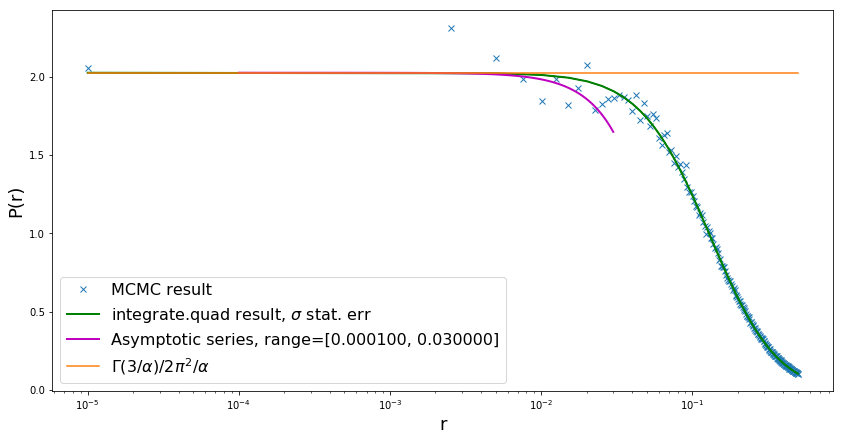

In [12]:
test(rrange=[0.00001, 0.5], alpha=0.6, xfu=15, xfl=4, num_samples=2000000, R=1, aa_sx=1e-4, ab_sx=3*1e-2, n=4)

## Large r behaviour

Seconds:1.91
Seconds:1.89
Seconds:1.65


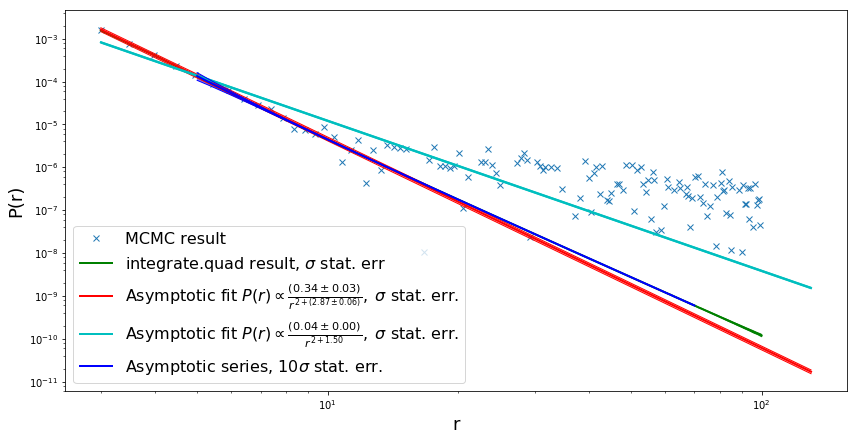

In [14]:
test(rrange=[3, 100], alpha=1.5, xfu=15, xfl=4, num_samples=2000000, R=1, aa=5, ab=70, n=4)

Seconds:1.91
Seconds:1.89
Seconds:7.30


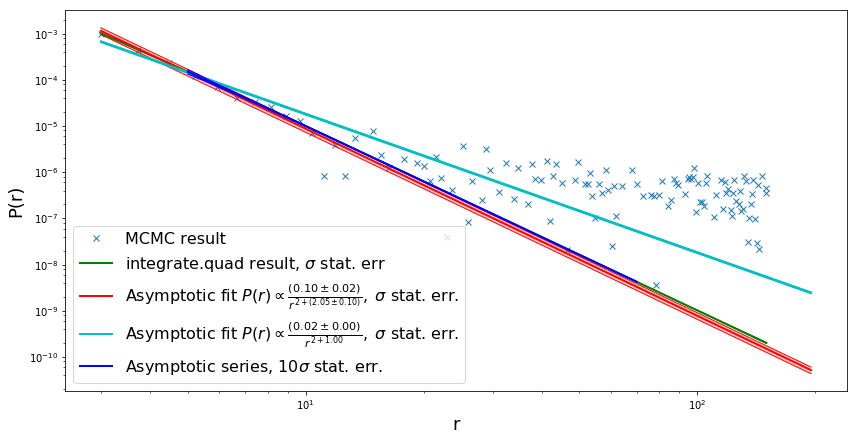

In [16]:
test(rrange=[3, 150], alpha=1, xfu=15, xfl=4, num_samples=2000000, R=1, aa=5, ab=70, n=4)

Seconds:1.91
Seconds:1.89
Seconds:6.86


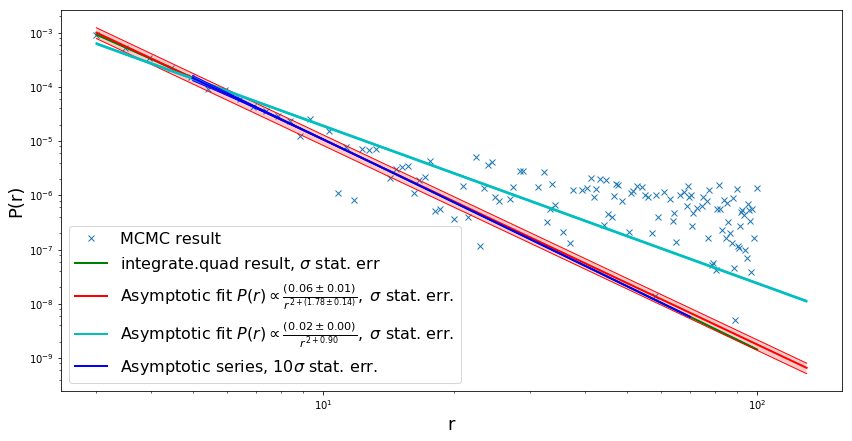

In [17]:
test(rrange=[3, 100], alpha=0.9, xfu=15, xfl=4, num_samples=2000000, R=1, aa=5, ab=70, n=4)

Seconds:1.91
Seconds:1.89
Seconds:4.77


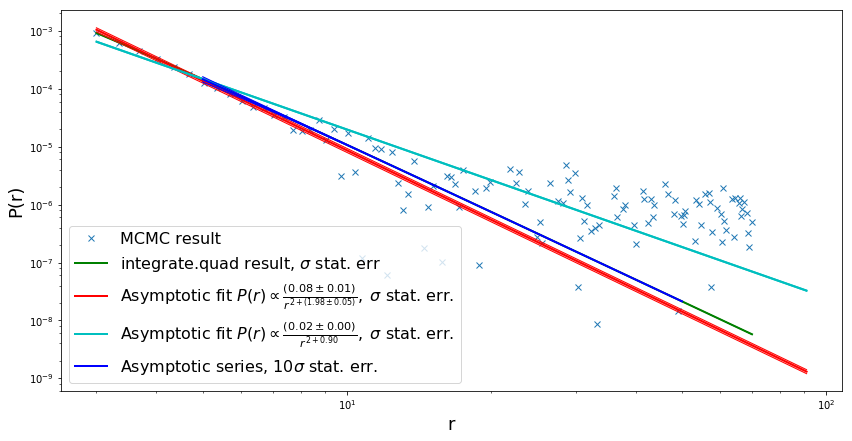

In [18]:
test(rrange=[3, 70], alpha=0.9, xfu=30, xfl=4, num_samples=2000000, R=1, aa=5, ab=50, n=4)

Seconds:1.90
Seconds:1.89
Seconds:8.58


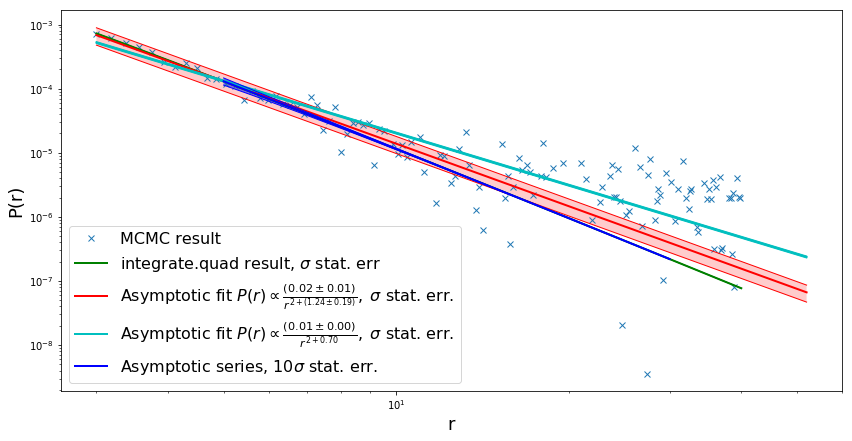

In [21]:
test(rrange=[3, 40], alpha=0.7, xfu=10, xfl=4, num_samples=2000000, R=1, aa=5, ab=30, n=4)

Seconds:1.91
Seconds:1.89


C:\Users\qati\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Seconds:17.80


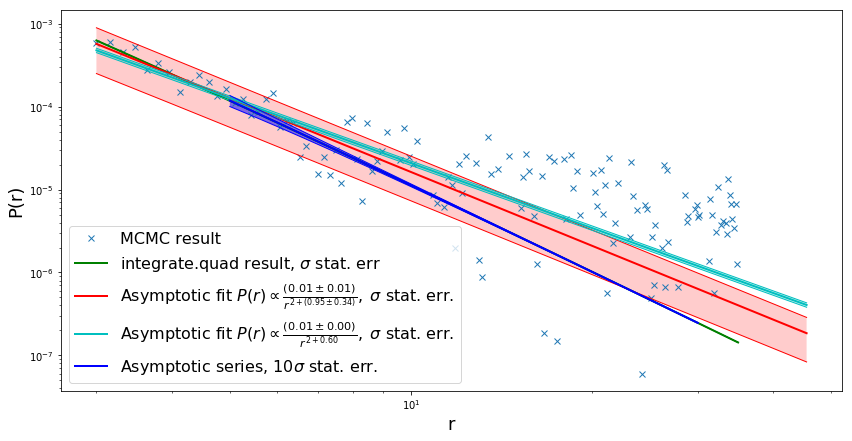

In [22]:
test(rrange=[3, 35], alpha=0.6, xfu=10, xfl=4, num_samples=2000000, R=1, aa=5, ab=30, n=4)